# **Proyecto de Minería de Datos: Predicción del Precio de Viviendas**

### **Autor:**  
**Deyvis Quispe Mamani**

### **Curso:**  
**Minería de Datos**

### **Docente:**  
**Abel Ángel Sullón Macalupu**

---

### **Descripción del Proyecto**

En este proyecto se aplican técnicas de **minería de datos y aprendizaje automático supervisado** para abordar un problema de **regresión**, cuyo objetivo es **predecir el precio de venta de viviendas** en función de diversas características físicas y de ubicación.

El análisis sigue un flujo completo de trabajo que abarca:

1. **Carga y exploración de los datos.**  
2. **Separación de los conjuntos de entrenamiento y prueba.**  
3. **Preprocesamiento** de variables numéricas y categóricas mediante *pipelines* con `ColumnTransformer`.  
4. **Entrenamiento de múltiples modelos de regresión**, incluyendo:  
   - Regresión Lineal  
   - Ridge  
   - Lasso  
   - Random Forest Regressor  
   - Support Vector Regressor (SVR)  
5. **Evaluación del rendimiento** utilizando métricas como **MAE**, **RMSE** y **R²**.  
6. **Visualización de resultados** mediante gráficos de dispersión (*Predicho vs Real*) y análisis de **residuos**.  
7. **Exportación del modelo entrenado** con `joblib` y creación de funciones `predict_one` y `predict_batch` para realizar inferencias futuras.

---

### **Estructura del Archivo**

El notebook mantiene la estructura y el formato empleados en los trabajos de laboratorio previos, con secciones numeradas que facilitan la ejecución secuencial y la comprensión del flujo de análisis de datos.

---

### **Palabras clave**
`Minería de Datos`, `Regresión`, `Aprendizaje Automático`, `Predicción de Precios`, `Python`, `Scikit-learn`

---


In [1]:
# =========================================
# 1) Cargar datos y definir objetivo
# =========================================
import os, warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_FILE = "/content/precio_viviendas_data.csv"
TARGET    = "Precio_USD"
assert os.path.exists(DATA_FILE), f"No se encuentra {DATA_FILE}"

df = pd.read_csv(DATA_FILE)
print("Dimensiones:", df.shape)
print("Columnas:", list(df.columns))
display(df.head())

X = df.drop(columns=[TARGET])
y = df[TARGET]
y.describe().to_frame("Precio_USD")


Dimensiones: (2200, 8)
Columnas: ['Distrito', 'Area_m2', 'Habitaciones', 'Banos', 'Antiguedad_anos', 'Piso', 'Tiene_Cochera', 'Precio_USD']


,Distrito,Area_m2,Habitaciones,Banos,Antiguedad_anos,Piso,Tiene_Cochera,Precio_USD
0,Pueblo Libre,115.0,4,4,13,10,Si,242112
1,San Miguel,104.7,5,4,35,8,No,161238
2,Magdalena,147.8,4,3,34,6,No,286570
3,San Isidro,28.0,4,3,43,15,Si,110847
4,Barranco,129.9,5,4,24,2,Si,320971


,Precio_USD
count,2200.000000
mean,188261.547727
std,83492.351494
min,45000.000000
25%,128134.500000
50%,181044.000000
75%,237609.250000
max,540828.000000


In [2]:
# =========================================
# 2) Train / Test Split
# =========================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)
X_train.shape, X_test.shape


((1650, 7), (550, 7))

In [3]:
# =========================================
# 3) Preprocesamiento
# =========================================
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_features = X.select_dtypes(include=["int64","float64","int32","float32"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

numeric_pipe = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_features),
        ("cat", categorical_pipe, cat_features),
    ]
)
num_features, cat_features


(['Area_m2', 'Habitaciones', 'Banos', 'Antiguedad_anos', 'Piso'],
 ['Distrito', 'Tiene_Cochera'])

In [4]:
# =========================================
# 4) Modelos a comparar (Regresión)
# =========================================
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

models = {
    "linreg": LinearRegression(),
    "ridge": RidgeCV(alphas=[0.1, 1.0, 10.0]),
    "lasso": LassoCV(alphas=[0.001, 0.01, 0.1, 1.0], max_iter=10000, random_state=RANDOM_STATE),
    "rf": RandomForestRegressor(n_estimators=400, random_state=RANDOM_STATE),
    "svr": SVR(kernel="rbf", C=10.0, epsilon=0.2)
}
list(models.keys())


['linreg', 'ridge', 'lasso', 'rf', 'svr']

In [6]:
# =========================================
# 5) Entrenamiento y evaluación
# =========================================
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

results = []
fitted = {}

for name, reg in models.items():
    pipe = Pipeline(steps=[("prep", preprocess), ("reg", reg)])
    pipe.fit(X_train, y_train)
    fitted[name] = pipe

    y_pred = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    # rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    r2 = r2_score(y_test, y_pred)
    results.append({"model": name, "MAE": mae, "RMSE": rmse, "R2": r2})

res_df = pd.DataFrame(results).sort_values(by=["R2"], ascending=False)
display(res_df)

best_name = res_df.iloc[0]["model"]
best_model = fitted[best_name]
print("Mejor modelo:", best_name)


,model,MAE,RMSE,R2
0,linreg,22611.247639,28416.301458,0.890781
2,lasso,22611.358451,28416.568274,0.890779
1,ridge,22609.660058,28418.628830,0.890764
3,rf,22891.005155,28901.426746,0.887020
4,svr,67448.755315,86208.528285,-0.005222


Mejor modelo: linreg


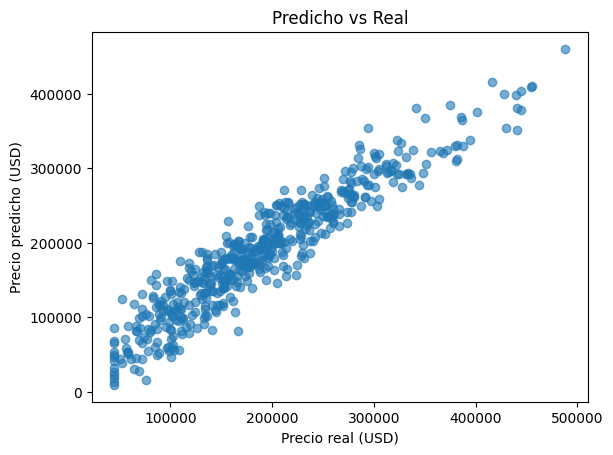

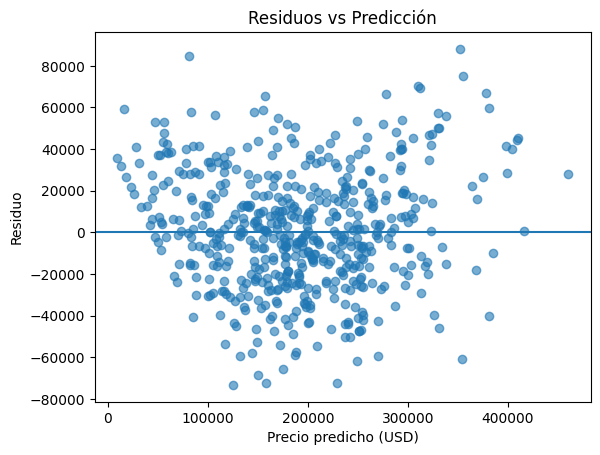

In [7]:
# =========================================
# 6) Diagnóstico visual: Predicho vs Real y Residuos
# (Gráficos con matplotlib; una figura por gráfico)
# =========================================
import matplotlib.pyplot as plt
import numpy as np

y_pred_best = best_model.predict(X_test)

plt.figure()
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.xlabel("Precio real (USD)")
plt.ylabel("Precio predicho (USD)")
plt.title("Predicho vs Real")
plt.show()

plt.figure()
res = y_test - y_pred_best
plt.scatter(y_pred_best, res, alpha=0.6)
plt.axhline(0)
plt.xlabel("Precio predicho (USD)")
plt.ylabel("Residuo")
plt.title("Residuos vs Predicción")
plt.show()


In [8]:
# =========================================
# 7) Importancias (si el modelo lo permite)
# =========================================
import numpy as np
import pandas as pd

def feature_names_after_preprocess(preprocess, X):
    names = []
    for name, trans, cols in preprocess.transformers_:
        if name == "num":
            names.extend(cols)
        elif name == "cat":
            # Extraccion nombres de OneHotEncoder
            ohe = trans.named_steps["onehot"]
            cat_names = ohe.get_feature_names_out(cols).tolist()
            names.extend(cat_names)
    return names

if hasattr(best_model.named_steps["reg"], "feature_importances_"):
    names = feature_names_after_preprocess(best_model.named_steps["prep"], X_train)
    importances = best_model.named_steps["reg"].feature_importances_
    imp_df = pd.DataFrame({"feature": names, "importance": importances}).sort_values("importance", ascending=False).head(20)
    display(imp_df)
else:
    print("El mejor modelo no expone importancias directas (p.ej., SVR o Lasso con coeficientes no comparables).")


El mejor modelo no expone importancias directas (p.ej., SVR o Lasso con coeficientes no comparables).


In [9]:
# =========================================
# 8) Persistencia
# =========================================
import joblib, os

ARTIFACT_BEST = "model_best_reg.joblib"
ARTIFACT_PREP = "preprocess_reg.joblib"

joblib.dump(best_model, ARTIFACT_BEST)
joblib.dump(preprocess, ARTIFACT_PREP)

os.path.exists(ARTIFACT_BEST), os.path.exists(ARTIFACT_PREP)


(True, True)

In [10]:
# =========================================
# 9) Esquema de entrada y funciones de predicción
# =========================================
import pandas as pd
import numpy as np
import joblib

INPUT_SCHEMA = {
    "Distrito": "string",
    "Area_m2": "number",
    "Habitaciones": "number",
    "Banos": "number",
    "Antiguedad_anos": "number",
    "Piso": "number",
    "Tiene_Cochera": "string"
}

def _make_df_from_payload(d):
    return pd.DataFrame([d])[list(INPUT_SCHEMA.keys())]

def predict_one(payload: dict):
    mdl = joblib.load("model_best_reg.joblib")
    X_one = _make_df_from_payload(payload)
    pred  = mdl.predict(X_one)[0]
    return {"prediction_usd": float(pred)}

def predict_batch(payload_list):
    mdl = joblib.load("model_best_reg.joblib")
    Xb = pd.DataFrame(payload_list)[list(INPUT_SCHEMA.keys())]
    out_pred = mdl.predict(Xb)
    return pd.DataFrame({
        **{k: Xb[k] for k in Xb.columns},
        "pred_usd": out_pred
    })

payload_ejemplo = {
    "Distrito": "Surco",
    "Area_m2": 90,
    "Habitaciones": 3,
    "Banos": 2,
    "Antiguedad_anos": 8,
    "Piso": 5,
    "Tiene_Cochera": "Si"
}
payload_ejemplo


{'Distrito': 'Surco',
 'Area_m2': 90,
 'Habitaciones': 3,
 'Banos': 2,
 'Antiguedad_anos': 8,
 'Piso': 5,
 'Tiene_Cochera': 'Si'}

In [11]:
# =========================================
# 10) Ejemplos de inferencia en lote
# =========================================
import json
samples_json = """
[
  {"Distrito": "Miraflores", "Area_m2": 75, "Habitaciones": 2, "Banos": 2, "Antiguedad_anos": 12, "Piso": 7, "Tiene_Cochera": "No"},
  {"Distrito": "San Isidro", "Area_m2": 120, "Habitaciones": 3, "Banos": 3, "Antiguedad_anos": 5, "Piso": 10, "Tiene_Cochera": "Si"},
  {"Distrito": "San Miguel", "Area_m2": 65, "Habitaciones": 2, "Banos": 1, "Antiguedad_anos": 18, "Piso": 3, "Tiene_Cochera": "No"},
  {"Distrito": "Surco", "Area_m2": 95, "Habitaciones": 3, "Banos": 2, "Antiguedad_anos": 6, "Piso": 6, "Tiene_Cochera": "Si"}
]
""".strip()

samples = json.loads(samples_json)
predict_batch(samples).head()


,Distrito,Area_m2,Habitaciones,Banos,Antiguedad_anos,Piso,Tiene_Cochera,pred_usd
0,Miraflores,75,2,2,12,7,No,196915.619756
1,San Isidro,120,3,3,5,10,Si,343836.077882
2,San Miguel,65,2,1,18,3,No,80446.758146
3,Surco,95,3,2,6,6,Si,216189.604861
